In [37]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

else:
    %cd /home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
from bnn_models import *
from train_utils import *
from data_utils import *
from hpo_util import *
from exp_utils import *
plt.style.use('ggplot')
%load_ext autoreload

/home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
if SERVER:
    data_dir = "/home/abdu/bio_ai/moses-incons-pen-xp/data"
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"


### GDSC Cell Line

#### Tamoxifen

In [6]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_tamox_data = pd.read_csv(f"{gdsc_dir}/tamoxifen_response_gene_expr.csv")
gdsc_exp_tamox_data.shape

(406, 37265)

In [9]:
X, target = gdsc_exp_tamox_data.iloc[:,:-1], gdsc_exp_tamox_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
driver_sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [311]:
# landmark_genes_df = pd.read_table(f"{data_dir}/cell_line/cmap_L1000_genes.txt")
# landmark_genes = [sym.strip() for sym in landmark_genes_df["Symbol"].to_list() if sym in cols]
# len(landmark_genes)

970

In [15]:
X_selected = X[driver_sym_list]
X_selected.shape

(406, 768)

In [16]:
all_genes_ls = gdsc_exp_tamox_data.columns.to_list()
with open(f"{data_dir}/all_genes_lst.txt", "w") as fp:
    for gene in all_genes_ls:
        fp.write(f"{gene}\n")

In [17]:
with open(f"{data_dir}/cancer_driver_genes.txt", "w") as fp:
    for gene in driver_sym_list:
        fp.write(f"{gene}\n")

In [18]:
gprofiler_pathway_ann = pd.read_csv(f"{data_dir}/gProfiler_pawthway_intersections.csv")
gprofiler_pathway_ann

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections
0,KEGG,Transcriptional misregulation in cancer,KEGG:05202,2.450000e-90,89.610342,177,768,84,36430,"AFF1,ASPSCR1,ATF1,ATM,BAX,BCL6,BCL11B,BIRC3,CC..."
1,KEGG,Prostate cancer,KEGG:05215,4.950000e-59,58.305557,97,768,52,36430,"AKT1,AKT2,AKT3,AR,ARAF,BCL2,BRAF,CCND1,CCNE1,C..."
2,KEGG,PI3K-Akt signaling pathway,KEGG:04151,3.050000e-56,55.515223,352,768,80,36430,"AKT1,AKT2,AKT3,BCL2,BRCA1,CCND1,CCND2,CCND3,CC..."
3,KEGG,Human T-cell leukemia virus 1 infection,KEGG:05166,6.910000e-55,54.160428,219,768,66,36430,"AKT1,AKT2,AKT3,ATM,ATR,B2M,BAX,BUB1B,CALR,CCND..."
4,KEGG,Hepatitis B,KEGG:05161,1.270000e-51,50.896018,162,768,57,36430,"AKT1,AKT2,AKT3,ARAF,BAX,BCL2,BRAF,CASP8,CCNE1,..."
...,...,...,...,...,...,...,...,...,...,...
179,KEGG,Parkinson disease,KEGG:05012,1.831791e-02,1.737124,266,768,16,36430,"BAX,DAXX,DDIT3,GNAI2,GNAS,HTRA2,KEAP1,KIF5B,NF..."
180,KEGG,Gastric acid secretion,KEGG:04971,1.940727e-02,1.712036,76,768,8,36430,"ATP1A1,EZR,GNAI2,GNAQ,GNAS,PLCB4,PRKACA,PRKCB"
181,KEGG,Pertussis,KEGG:05133,1.940727e-02,1.712036,76,768,8,36430,"GNAI2,IRAK1,IRF1,JUN,MAPK1,MYD88,RELA,RHOA"
182,KEGG,Protein processing in endoplasmic reticulum,KEGG:04141,2.424009e-02,1.615466,168,768,12,36430,"BAX,BCL2,CALR,DDIT3,DNAJB1,HERPUD1,HSP90AA1,HS..."


In [19]:
def find_pathways(gene_lst, pathway_ann_df):
   n =  pathway_ann_df.shape[0]
   res_dict = {}
   for idx in range(n):
       row = pathway_ann_df.iloc[idx]
       pathway_name = row["term_name"]
       intrsec_genes = row["intersections"].split(',')
       common_genes = list(set(gene_lst) & set(intrsec_genes))
       if len(common_genes) != 0:
           res_dict[pathway_name] = common_genes


   return res_dict

In [20]:
p = X_selected.shape[-1]
cols = X_selected.columns
n = gprofiler_pathway_ann.shape[0]
J_pathways = np.zeros((p, p))
for idx in range(n):
    intrsec_genes = gprofiler_pathway_ann.iloc[idx]["intersections"].split(',')
    gene_locs = [cols.get_loc(gene) for gene in intrsec_genes]
    for loc1 in gene_locs:
        for loc2 in gene_locs:
            if loc1 != loc2:
                J_pathways[loc1, loc2] = 1.0

In [ ]:
# np.fill_diagonal(J_pathways, 0.)
# np.save(f"{data_dir}/cell_line/pathway_genes_net.npy" ,J_pathways)

#### Data Preprocessing

In [44]:
from scipy.sparse import csgraph
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
J_path = np.load(f"{data_dir}/cell_line/pathway_genes_net.npy")
J_lm = np.load(f"{data_dir}/cell_line/landmark_genes_net.npy")
print(f"Num intr in J: {np.count_nonzero(J)//2}\nNum intr in J_path: {np.count_nonzero(J_path)//2}, "
      f"\nNum intr in J_lm: {np.count_nonzero(J_lm)//2}")
J_zeros  = np.zeros_like(J)
L = csgraph.laplacian(J, normed=True)
L_lm = csgraph.laplacian(J_lm, normed=True)
L_path = csgraph.laplacian(J_path, normed=True)
np.fill_diagonal(L_path, 0.)
# print(np.count_nonzero(J_lm))

Num intr in J: 5931
Num intr in J_path: 27714, 
Num intr in J_lm: 4593


In [50]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler
seed = 220
# idxs = jax.random.choice(jax.random.PRNGKey(seed), jnp.arange(X_selected.shape[0]), (X_selected.shape[0] // 2, ), replace=False)
# X_selected_perm = X_selected.iloc[idxs]
# target_perm = target.iloc[idxs]
# print(X_selected_perm.shape)
transformer = QuantileTransformer(random_state=seed, output_distribution="normal")
X_train_outer, X_train, X_val, X_test, \
y_train_outer, y_train, y_val, y_test, _ = preprocess_data(seed, X_selected, target,
                                                          transformer, val_size=0.2, test_size=0.2)

In [54]:
%autoreload
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study_bnn = optuna.create_study(sampler=sampler)

study_bnn.optimize(lambda trial: objective_bg_bnn(trial, seed, X_train, X_val, y_train, y_val, J_zeros, 0.99, [500], "swish", bg=False), timeout=120)

[I 2023-02-17 02:08:21,621] A new study created in memory with name: no-name-2320121d-3a86-4711-9cc9-30a23689cb58
[I 2023-02-17 02:08:49,350] Trial 0 finished with value: 0.53871089220047 and parameters: {'lr_0': 0.001, 'disc_lr_0': 0.1, 'num_cycles': 50, 'temp': 0.001, 'batch_size': 16, 'sigma': 1.0, 'mu': 17.488286079623443}. Best is trial 0 with value: 0.53871089220047.
[I 2023-02-17 02:09:17,472] Trial 1 finished with value: 0.602079451084137 and parameters: {'lr_0': 0.001, 'disc_lr_0': 0.01, 'num_cycles': 30, 'temp': 0.1, 'batch_size': 16, 'sigma': 0.5, 'mu': 24.19457483379013}. Best is trial 0 with value: 0.53871089220047.
[I 2023-02-17 02:09:44,389] Trial 2 finished with value: 165.9013214111328 and parameters: {'lr_0': 0.1, 'disc_lr_0': 0.5, 'num_cycles': 10, 'temp': 0.01, 'batch_size': 16, 'sigma': 1.0, 'mu': 72.14970153169268}. Best is trial 0 with value: 0.53871089220047.
[I 2023-02-17 02:09:53,212] Trial 3 finished with value: 0.6036335229873657 and parameters: {'lr_0': 0.0

In [55]:
bnn_config = study_bnn.best_params
bnn_config

{'lr_0': 0.001,
 'disc_lr_0': 0.1,
 'num_cycles': 50,
 'temp': 0.001,
 'batch_size': 16,
 'sigma': 1.0,
 'mu': 17.488286079623443}

In [303]:
%autoreload
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study_bg = optuna.create_study(sampler=sampler)

study_bg.optimize(lambda trial: objective_bg_bnn(trial, seed, X_train, X_val, y_train, y_val, L, 0.99, [500], "swish", bg=True), timeout=120)

[I 2023-02-09 09:07:34,423] A new study created in memory with name: no-name-d8ab006a-1f9b-43a4-84a5-17ec333dc1c1
[I 2023-02-09 09:07:53,540] Trial 0 finished with value: 0.5173162817955017 and parameters: {'eta': 74.50308259581601, 'mu': 17.060047782144455}. Best is trial 0 with value: 0.5173162817955017.
[I 2023-02-09 09:08:12,507] Trial 1 finished with value: 0.5190597772598267 and parameters: {'eta': 4.678425300020363, 'mu': 73.68911693359384}. Best is trial 0 with value: 0.5173162817955017.
[I 2023-02-09 09:08:31,916] Trial 2 finished with value: 0.5502198338508606 and parameters: {'eta': 36.10018804212338, 'mu': 90.9474565265057}. Best is trial 0 with value: 0.5173162817955017.
[I 2023-02-09 09:08:50,647] Trial 3 finished with value: 0.502818763256073 and parameters: {'eta': 30.476435728982537, 'mu': 21.450254780216625}. Best is trial 3 with value: 0.502818763256073.
[I 2023-02-09 09:09:09,147] Trial 4 finished with value: 0.5128297805786133 and parameters: {'eta': 47.36665781957

In [304]:
bg_config = study_bg.best_params
bg_config

{'eta': 30.476435728982537, 'mu': 21.450254780216625}

In [51]:
import pickle
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamoxifen"
VERSION = "1b"
bnn_config = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "rb"))
bnn_bg_config = pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "rb"))
print(f"BNN config: {bnn_config}")
print(f"BG BNN config: {bnn_bg_config}")

BNN config: {'lr_0': 0.01, 'disc_lr_0': 0.5, 'num_cycles': 50, 'temp': 0.001, 'batch_size': 32, 'sigma': 0.5, 'mu': 92.56090510389446}
BG BNN config: {'lr_0': 0.001, 'disc_lr_0': 0.5, 'num_cycles': 50, 'temp': 0.01, 'batch_size': 64, 'sigma': 0.5, 'eta': 7.31874460186161, 'mu': 54.91077635396677}


In [57]:
%autoreload
lr_0, disc_lr_0 = bnn_config["lr_0"], 0.5
temp, sigma = bnn_config["temp"], bnn_config["sigma"]
epochs, num_cycles = 500, bnn_config["num_cycles"]
eta, mu = 1.0, bnn_config["mu"]
outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=bnn_config["batch_size"], shuffle=True,
                                drop_last=True)
bnn_model, bnn_states, bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles,
                                                                     0.25, 1, lr_0, disc_lr_0, [500], temp, sigma,
                                                                     eta, mu, J_zeros, "swish")

bnn_rmse_train, bnn_r2_train = score_bg_bnn_model(bnn_model, X_train, y_train, bnn_states, bnn_disc_states, True)
bnn_rmse_test, bnn_r2_test = score_bg_bnn_model(bnn_model, X_test, y_test, bnn_states, bnn_disc_states, True)
print(f"Train RMSE: {bnn_rmse_train}, r2_score: {bnn_r2_train}")
print(f"Test RMSE: {bnn_rmse_test}, r2_score: {bnn_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.75it/s]


Train RMSE: 0.23804090917110443, r2_score: 0.8229826459905336
Test RMSE: 0.4913429319858551, r2_score: 0.08292822362143482


In [31]:
%autoreload
lr_0, disc_lr_0 = 1e-3, 0.5
temp = 1.0
epochs, num_cycles = 500, 50
eta, mu = -bnn_bg_config["eta"], 100.0
outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=32, shuffle=True)
bg_bnn_model, bg_bnn_states, bg_bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles,
                                                                     0.25, 1, lr_0, disc_lr_0, [500], temp, 1.0,
                                                                     eta, mu, L, "swish")

print(len(bg_bnn_states))
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bg_bnn_states, bg_bnn_disc_states, True)
print(f"Test RMSE: {bnn_bg_rmse_test}, r2_score: {bnn_bg_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.23it/s]


50
Test RMSE: 0.569378137588501, r2_score: -0.08468985069419555


#### Multiple Runs

In [40]:
%autoreload
import warnings
warnings.filterwarnings("ignore")

hp_configs = {"epochs": 500, "num_cycles": 50, "batch_size": 32, "act_fn": "swish",
              "beta": 0.25, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [500],
              "temp": 1.0, "sigma": 1.0, "num_models": 2}

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"

VERSION = "10b"

seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
print(len(curr_seeds))
# cross_val_runs(curr_seeds, X_selected, target, L, VERSION, save_dir, saved_config=False, **hp_configs)

20


Temp 1e-4, epochs 1000, num_cycles 50

In [96]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v9f.csv")
    res_dfs.append(df)

bnn_rf_df_9f = pd.concat(res_dfs, axis=0, ignore_index=True)
bnn_rf_df_9f = bnn_rf_df_9f.drop_duplicates()
bnn_rf_df_9f.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.471317,0.270662
BNN w/o BG,0.471387,0.270160
RF,0.477881,0.251800


v10a - Temp = 1, epochs 500, num_cycles 50, BG - J

In [326]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v10a.csv")
    res_dfs.append(df)

bnn_rf_df_10c = pd.concat(res_dfs, axis=0, ignore_index=True)
# bnn_rf_df_10a = bnn_rf_df_10a.drop_duplicates()
bnn_rf_df_10c.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.473803,0.259835
BNN w/o BG,0.470240,0.274097
RF,0.477881,0.251800


v10b - Temp = 1, epochs 500, num_cycles 50, BG - L

In [41]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v10b.csv")
    res_dfs.append(df)

bnn_rf_df_10b = pd.concat(res_dfs, axis=0, ignore_index=True)
# bnn_rf_df_10b = bnn_rf_df_10b.drop_duplicates()
bnn_rf_df_10b.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.471168,0.270877
BNN w/o BG,0.470136,0.274926
RF,0.477881,0.251800


In [43]:
bnn_rf_df_10b

,seed,model,test_rmse,test_r2_score
0,422,RF,0.413302,0.258317
1,422,BNN w/o BG,0.409270,0.272717
2,422,BNN + BG,0.408352,0.275976
3,261,RF,0.470812,0.218743
4,261,BNN w/o BG,0.472014,0.214749
5,261,BNN + BG,0.475199,0.204115
6,968,RF,0.488419,0.255486
7,968,BNN w/o BG,0.483350,0.270860
8,968,BNN + BG,0.483929,0.269111
9,282,RF,0.517290,0.232802


In [329]:
import pickle
bg_bnn_configs = []
for seed in curr_seeds:
    bg_bnn_configs.append(pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v10b.pkl", "rb")))

In [330]:
bnn_configs = []
for seed in curr_seeds:
    bnn_configs.append(pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "rb")))

In [331]:
pd.DataFrame(bg_bnn_configs)

,eta,eta_sign,mu
0,25.478518,-1,73.468346
1,59.883145,-1,19.270437
2,46.153780,1,81.844963
3,96.369248,1,62.603906
4,88.500345,-1,15.354244
5,45.580567,-1,91.615710
6,58.360078,1,41.208532
7,70.172040,-1,81.303200
8,42.482630,-1,28.196320
9,35.680705,-1,16.125581


#### Zero-Out Ranking

In [333]:
%autoreload
hp_configs = {"epochs": 500, "num_cycles": 50, "batch_size": 32, "act_fn": "swish",
              "beta": 0.36, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [500],
              "temp": 1.0, "sigma": 1.0, "num_models": 2}

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"

VERSION = "10b"

seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
num_feats = [10, 20, 30, 40, 50]
curr_seeds = seeds
# zero_out_ranking(curr_seeds, X_selected, target, L_path, num_feats,
#                     VERSION, save_dir, dropout=False, **hp_configs)

v9g - Temp 1e-4, epochs 1000, num_cycles 50, BG - J

In [102]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_ig_v9g.csv")
    res_dfs.append(df)

bg_bnn_res_zero_out_9g = pd.concat(res_dfs, axis=0)
# bg_bnn_res_zero_out_9g = bg_bnn_res_zero_out_9g.drop_duplicates()
bg_bnn_res_zero_out_9g.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score
model    num_feats                 
BNN      10                0.551111
         20                0.545321
         30                0.544436
         40                0.544135
         50                0.543092
BNN + BG 10                0.571584
         20                0.582861
         30                0.578153
         40                0.572242
         50                0.564017
RF       10                0.548019
         20                0.537257
         30                0.529850
         40                0.524423
         50                0.519199

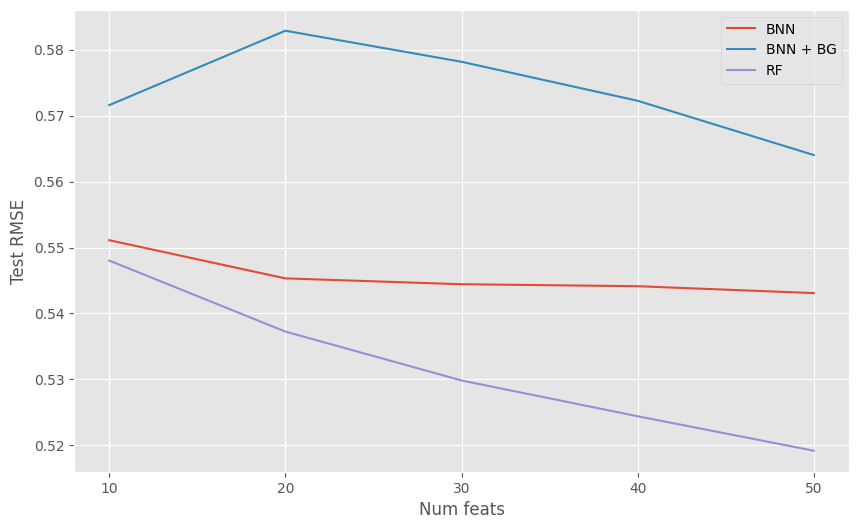

In [103]:
plt.rcParams["figure.figsize"] = (10,6)
for model in ["BNN", "BNN + BG", "RF"]:
    plt.plot(num_feats, bg_bnn_res_zero_out_9g[bg_bnn_res_zero_out_9g["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    plt.xticks(num_feats)
    plt.ylabel("Test RMSE")
    plt.xlabel("Num feats")
    plt.legend()

v10a - Temp = 1, epochs 500, num_cycles 50, BG - J

In [334]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs_1 = []
res_dfs_2 = []
for seed in curr_seeds:
    df_1 = pd.read_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_ig_v10a.csv")
    df_2 = pd.read_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_ig_v10b.csv")
    res_dfs_1.append(df_1)
    res_dfs_2.append(df_2)

bg_bnn_res_zero_out_10a = pd.concat(res_dfs_1, axis=0)
bg_bnn_res_zero_out_10b = pd.concat(res_dfs_2, axis=0)

In [561]:
bg_bnn_res_zero_out_10b[bg_bnn_res_zero_out_10b["num_feats"] == 50]

,seed,model,num_feats,test_rmse_score
12,422,RF,50,0.449106
13,422,BNN,50,0.443451
14,422,BNN + BG,50,0.477619
12,261,RF,50,0.509588
13,261,BNN,50,0.528512
14,261,BNN + BG,50,0.626080
12,968,RF,50,0.528381
13,968,BNN,50,0.526984
14,968,BNN + BG,50,0.531356
12,282,RF,50,0.549775


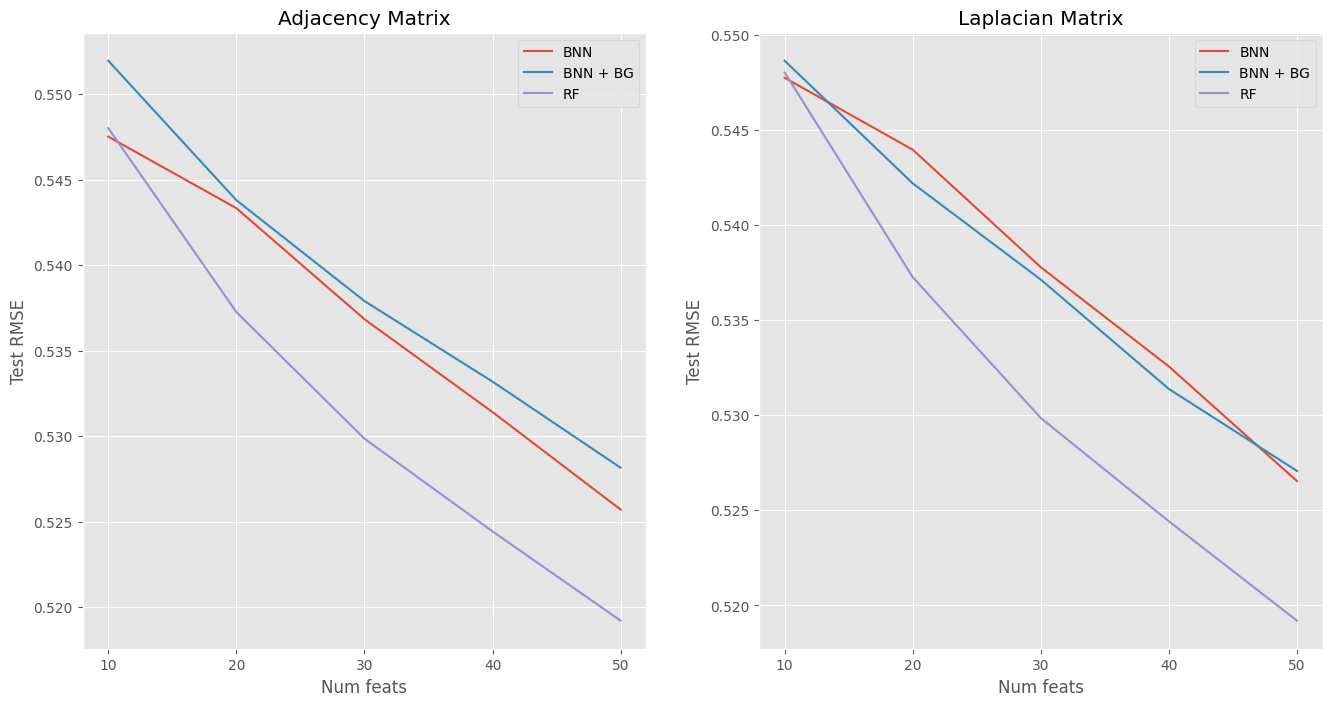

In [335]:
# plt.rcParams["figure.figsize"] = (10,6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
for model in ["BNN", "BNN + BG", "RF"]:
    ax1.plot(num_feats, bg_bnn_res_zero_out_10a[bg_bnn_res_zero_out_10a["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    ax1.set_xticks(num_feats)
    ax1.set_ylabel("Test RMSE")
    ax1.set_xlabel("Num feats")
    ax1.set_title("Adjacency Matrix")

    ax2.plot(num_feats, bg_bnn_res_zero_out_10b[bg_bnn_res_zero_out_10b["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    ax2.set_xticks(num_feats)
    ax2.set_ylabel("Test RMSE")
    ax2.set_xlabel("Num feats")
    ax2.set_title("Laplacian Matrix")

    ax1.legend()
    ax2.legend()

In [176]:
k = 20
bg_rmse  = bg_bnn_res_zero_out_10b[(bg_bnn_res_zero_out_10b["model"] == "BNN + BG") & (bg_bnn_res_zero_out_10b["num_feats"] == k)]["test_rmse_score"].to_list()
bnn_rmse  = bg_bnn_res_zero_out_10b[(bg_bnn_res_zero_out_10b["model"] == "BNN") & (bg_bnn_res_zero_out_10b["num_feats"] == k)]["test_rmse_score"].to_list()
rf_rmse = bg_bnn_res_zero_out_10b[(bg_bnn_res_zero_out_10b["model"] == "RF") & (bg_bnn_res_zero_out_10b["num_feats"] == k)]["test_rmse_score"].to_list()
bg_bnn_res_zero_out_10b[(bg_bnn_res_zero_out_10b["num_feats"] == k)].groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score
model,num_feats,
BNN,20,0.543957
BNN + BG,20,0.542187
RF,20,0.537257


In [177]:
stats.ttest_rel(bg_rmse, bnn_rmse, alternative="less")

TtestResult(statistic=-1.1609539148874124, pvalue=0.13001980455982637, df=19)

#### Retrain Ranking

In [117]:
import warnings
warnings.filterwarnings("ignore")
from exp_utils import retrain_with_mlp
%autoreload
retrain_hp_configs = {"epochs": 500, "num_cycles": 50, "batch_size": 32, "act_fn": "swish",
              "beta": 0.36, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [500],
              "temp": 1.0, "sigma": 1.0, "num_models": 2,
              "mlp_config": {"epochs": 500, "lr_0": 1e-3, "hidden_sizes": [50],
                             "act_fn": "swish"}}

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"

VERSION = "10a"

num_feats = [10, 20, 30, 40, 50]
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
retrain_with_mlp(curr_seeds, X_selected, target, J, num_feats, VERSION, save_dir, dropout=False,
                 **retrain_hp_configs)

In [119]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs_1 = []
res_dfs_2 = []
for seed in curr_seeds:
    df_1 = pd.read_csv(f"{save_dir}/results/feat_retrain_comp_bnn_bg_rf_s_{seed}_ig_v10a.csv")
    df_2 = pd.read_csv(f"{save_dir}/results/feat_retrain_comp_bnn_bg_rf_s_{seed}_ig_v10b.csv")
    res_dfs_1.append(df_1)
    res_dfs_2.append(df_2)

bg_bnn_res_retrain_10a = pd.concat(res_dfs_1, axis=0)
bg_bnn_res_retrain_10b = pd.concat(res_dfs_2, axis=0)

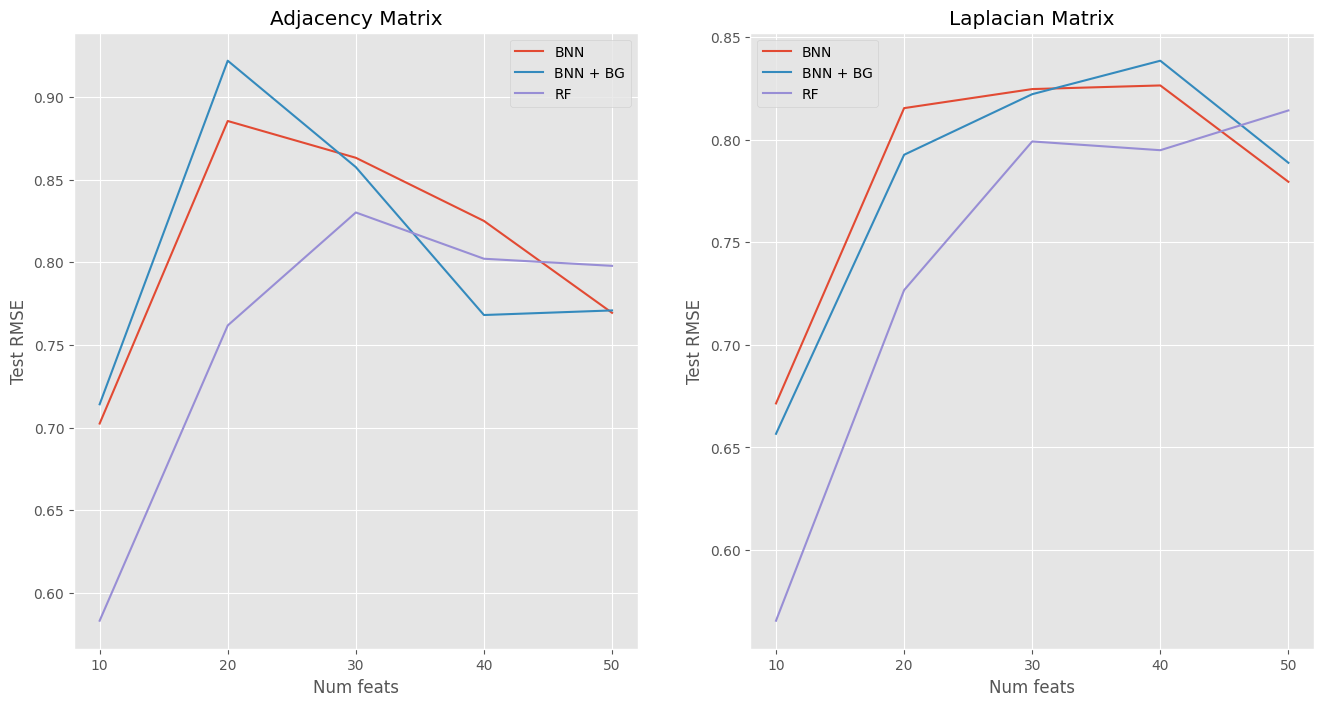

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
for model in ["BNN", "BNN + BG", "RF"]:
    ax1.plot(num_feats, bg_bnn_res_retrain_10a[bg_bnn_res_retrain_10a["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    ax1.set_xticks(num_feats)
    ax1.set_ylabel("Test RMSE")
    ax1.set_xlabel("Num feats")
    ax1.set_title("Adjacency Matrix")

    ax2.plot(num_feats, bg_bnn_res_retrain_10b[bg_bnn_res_retrain_10b["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    ax2.set_xticks(num_feats)
    ax2.set_ylabel("Test RMSE")
    ax2.set_xlabel("Num feats")
    ax2.set_title("Laplacian Matrix")

    ax1.legend()
    ax2.legend()

In [182]:
k = 20
bg_rmse  = bg_bnn_res_retrain_10a[(bg_bnn_res_retrain_10a["model"] == "BNN + BG") & (bg_bnn_res_retrain_10a["num_feats"] == k)]["test_rmse_score"].to_list()
bnn_rmse  = bg_bnn_res_retrain_10a[(bg_bnn_res_retrain_10a["model"] == "BNN") & (bg_bnn_res_retrain_10a["num_feats"] == k)]["test_rmse_score"].to_list()
rf_rmse = bg_bnn_res_retrain_10a[(bg_bnn_res_retrain_10a["model"] == "RF") & (bg_bnn_res_retrain_10a["num_feats"] == k)]["test_rmse_score"].to_list()
bg_bnn_res_retrain_10a[(bg_bnn_res_retrain_10a["num_feats"] == k)].groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score
model,num_feats,
BNN,20,0.885370
BNN + BG,20,0.921816
RF,20,0.761765


In [184]:
stats.ttest_rel(bg_rmse, bnn_rmse, alternative="greater")

TtestResult(statistic=1.2703783301345728, pvalue=0.10964326570602786, df=19)